# Fine-tuning a VLM for Structured Food Tag Extraction

Goal:
* Input: Food or not food image
* Output: Structured data for whether or not the image is food or not + food/ drink tags

## Resources
* Docs example of fine-tuning a VLM: https://ai.google.dev/gemma/docs/core/huggingface_vision_finetune_qlora?hl=tr
* Another doc example of inference with a VLM: https://github.com/google-gemini/gemma-cookbook/blob/main/Gemma/[Gemma_3n]Multimodal_understanding_with_HF.ipynb
* LoRa without regret https://huggingface.co/docs/trl/main/en/index
    * Thinking Machines blog: https://thinkingmachines.ai/blog/lora/
* Example of LoRA in the wild: https://developer.apple.com/apple-intelligence/foundation-models-adapter/

* PEFT (Parameter Efficient Fine-tuning) GitHub - https://github.com/huggingface/peft

## Definitions

* PEFT = Parameter Efficient Fine-Tuning (only train a subset of the model parameters + hopefully still get good results)

* LORA = Low Rank Adaptation (LoRA = a form of PET)
    * You basically fine-tune an adapter model for your original model and optionally apply the adapter to the original model
    * Benefits of LoRA = you can train multiple adapters only and run different times depending on the required use case of your model

* QloRA = Quantized LoRA (fine-tune an adapter)
    * Train with quantized weights (even smaller than LoRA) for even more parameter efficient fine-tuning

In [1]:
!pip install -U bitsandbytes accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 45.2 MB/s eta 0:00:00


In [2]:
!pip install trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 39.0 MB/s eta 0:00:00


In [3]:
import transformers
import torch
import trl

from peft import LoraConfig
from transformers import BitsAndBytesConfig

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## Load Dataset

In [5]:
from datasets import load_dataset
from PIL import Image

dataset = load_dataset("berkeruveyik/vlm-food-4k-not-food-dataset")
dataset

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/263M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3698 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'category', 'output_json', 'output_yaml', 'image_name', 'image_id', 'food270_class_name', 'image_source', 'label'],
        num_rows: 3698
    })
})

In [6]:
example_sample =dataset['train'][330]
example_sample

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'category': 'beignets',
 'output_json': {'is_food': 1,
  'image_title': 'beignets',
  'food_items': ['sugar',
   'flour',
   'butter',
   'eggs',
   'milk',
   'cinnamon',
   'nutmeg',
   'vanilla extract'],
  'drink_items': []},
 'output_yaml': {'is_food': 1,
  'image_title': 'beignets',
  'food_items': ['sugar',
   'flour',
   'butter',
   'eggs',
   'milk',
   'cinnamon',
   'nutmeg',
   'vanilla extract'],
  'drink_items': []},
 'image_name': '26e72132134c47b0a9a3af5da2642ceb.jpg',
 'image_id': '26e72132134c47b0a9a3af5da2642ceb',
 'food270_class_name': 'beignets',
 'image_source': 'food270',
 'label': 1}

[INFO] Example output: {'is_food': 1, 'image_title': 'beignets', 'food_items': ['sugar', 'flour', 'butter', 'eggs', 'milk', 'cinnamon', 'nutmeg', 'vanilla extract'], 'drink_items': []}


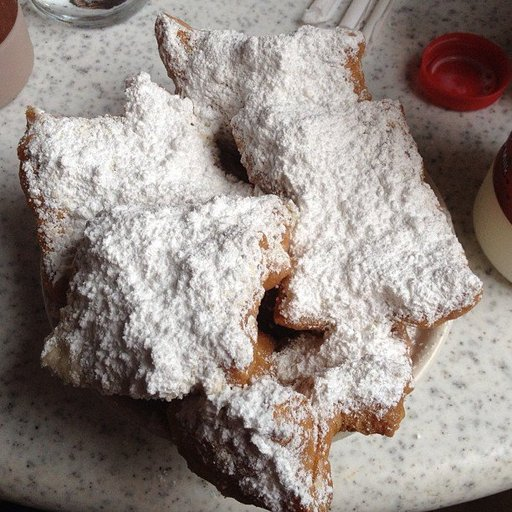

In [7]:
example_input = example_sample['image']
example_output = example_sample['output_json']

print(f'[INFO] Example output: {example_output}')
example_input

## format data for use with a VLM
* Input: image
* Output: structured json data with food tags

In [8]:
# system mesage
SYSTEM_MESSAGE = """ You are an expert food and drink image extractor.
You provide structured data to visual inputs classifying them as edible food/drink or not.
as well as titling the image with a simple simple food/drink related caption.
Finally you extract any and all visible food/drink items to lists.
"""

# user prompt with image input as well ass desired output
USER_PROMPT = """ Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.

Only return valid JSON in the following form:

```json

{
    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)
    'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present
    'food_items' : [], # list[str] - list of visible edible food item nouns
    'drink_items': [] # list[str] - list of visible edible drink item nouns
}
```
"""

# create helper function to map our input/output sample to conversational format
def format_data(sample):
    return{
        'messages':[
            # Message 0 - [SYSTEM] System prompt (setting the scene)
            {
                'role': 'system',
                'content': [{'type':'text', 'text': SYSTEM_MESSAGE}]
            },
            # Message 1 - [USER] User input (image + prompt pair)
            {
                'role': 'user',
                'content': [
                    {
                        'type': 'image',
                        'image': sample['image']
                    },
                    {
                        'type': 'text',
                        'text': USER_PROMPT
                    },
                ]
            },
            # Message 2 - [MODEL] Ideal model output (structured json data)
            {
                'role': 'assistant',
                'content': [
                    {
                        'type': 'text',
                        'text': sample['output_json']
                    }
                ]
            },
        ]
    }

formatted_sample = format_data(example_sample)
formatted_sample

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': ' You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nas well as titling the image with a simple simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>},
    {'type': 'text',
     'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the ima

In [9]:
# Format each item in the original dataset keeping the PIL image type
# Note: If we use •map(), image may get converted to bytes
dataset_processed = [format_data(sample) for sample in dataset["train"]]
dataset_processed[0]

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': ' You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nas well as titling the image with a simple simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>},
    {'type': 'text',
     'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the ima

In [10]:
# this took too long skipping for now
'''
dataset = dataset.map(format_data,
                      batched=False)

dataset["train"][0]

'''

'\ndataset = dataset.map(format_data,\n                      batched=False)\n\ndataset["train"][0]\n\n'

## Running a sample through a base model

Let's see how a non-fine-tuned model performs on our task.

To begin with we'll try out Genma-3n-E2B-It - https://hug9ingface.co/9009le/gemma-30-E28-It~

In [11]:
example_base_model_input = dataset_processed[330]['messages'][:2]  # only input messages (no output)
example_base_model_input

[{'role': 'system',
  'content': [{'type': 'text',
    'text': ' You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nas well as titling the image with a simple simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>},
   {'type': 'text',
    'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if n

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import pipeline
from google.colab import userdata
import torch # Ensure torch is imported for torch.bfloat16

MODEL_ID = 'google/gemma-3n-E2B-it'

# Retrieve the Hugging Face token from Colab secrets
hf_token = userdata.get('HF_TOKEN')

pipe = pipeline(
    'image-text-to-text',
    model=MODEL_ID,
    device='cuda',
    dtype=torch.bfloat16, # Use torch_dtype explicitly for better consistency
    token=hf_token  # Pass the token explicitly
)

config.json:   0%|          | 0.00/4.25k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/159k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/2.82G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

Device set to use cuda


In [ ]:
# Test the base model on an example input image
base_model_output = pipe(example_base_model_input,
                         max_new_tokens=256)

print(f"[INFO] Base model output:\n{base_model_output[0]['generated_text'][-1]['content']}")


[INFO] Base model output:
```json
{
    'is_food': 1,
    'image_title': 'Powdered Beignets',
    'food_items' : ['beignets'],
    'drink_items': []
}
```


In [ ]:
print(f'[INFO] Ideal model output:\n')
example_sample['output_json']

[INFO] Ideal model output:



{'is_food': 1,
 'image_title': 'beignets',
 'food_items': ['sugar',
  'flour',
  'butter',
  'eggs',
  'milk',
  'cinnamon',
  'nutmeg',
  'vanilla extract'],
 'drink_items': []}

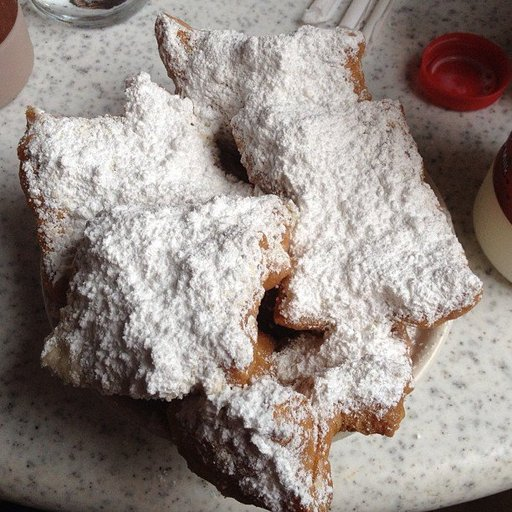

In [ ]:
example_base_model_input[1]['content'][0]['image']

## Load the model without using pipline

`transformers. pipelin` allows simple loading and inference of the model.

But for more customization we'll want to load the model directly.|

In [12]:
# Load model in non-pipline way for more customization on the load
# Improve base model to be mode aligned with our ideal outputs

import torch
from transformers import BitsAndBytesConfig, AutoModelForImageTextToText,AutoProcessor

MODEL_ID = "google/gemma-3n-e2b-it"
print(f'[INFO] using model {MODEL_ID}')

# define model init args
model_kwargs = dict(
    attn_implementation='eager',
    dtype=torch.bfloat16,
    device_map='auto'
)

# BitsAndBytesConfig int-4 config
# TK - Load the model in 4bit for smaller footprint? Not 100% sure on this...
# Note: If you are loading a quantized model, make sure the inputs are quantized as well,otherwise you will get errors.

#model_kwargs['quantization_config'] = BitsAndBytesConfig(
#    load_in_4bit=True,
#    bnb_4bit_use_double_quant=True,
#    bnb_4bit_quant_type="nf4",
#    bnb_4bit_compute_dtype=model_kwargs["dtype"],
#    bnb_4bit_quant_storage=model_kwargs["dtype"]
#    )

model = AutoModelForImageTextToText.from_pretrained(MODEL_ID,
                                                    **model_kwargs)
processor = AutoProcessor.from_pretrained(MODEL_ID)

[INFO] using model google/gemma-3n-e2b-it


config.json:   0%|          | 0.00/4.25k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/159k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/2.82G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

In [13]:
model

Gemma3nForConditionalGeneration(
  (model): Gemma3nModel(
    (vision_tower): TimmWrapperModel(
      (timm_model): MobileNetV5Encoder(
        (conv_stem): ConvNormAct(
          (conv): Conv2dSame(3, 64, kernel_size=(3, 3), stride=(2, 2))
          (bn): RmsNormAct2d(
            (drop): Identity()
            (act): GELU(approximate='tanh')
          )
        )
        (blocks): Sequential(
          (0): Sequential(
            (0): EdgeResidual(
              (conv_exp): Conv2dSame(64, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
              (bn1): RmsNormAct2d(
                (drop): Identity()
                (act): GELU(approximate='tanh')
              )
              (aa): Identity()
              (se): Identity()
              (conv_pwl): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn2): RmsNormAct2d(
                (drop): Identity()
                (act): Identity()
              )
              (drop_path): Identity()
       

In [ ]:
#example_base_model_input_clone = example_base_model_input
#example_base_model_input_clone

In [ ]:
#example_base_model_input_clone[1]['content'][0]['image'] = 'https://101limerick.com/wp-content/uploads/2025/08/Screenshot-2025-08-26-at-16.23.50.png'

In [ ]:
#example_base_model_input_clone[1]

In [ ]:
#example_base_model_input[1]

In [14]:
# Run the model on our example sample
example_chat_template_input = processor.apply_chat_template(
    [example_base_model_input[1]],
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors='pt'
).to(model.device, dtype=torch.bfloat16) # Move input to model's device and dtype, ensuring type consistency

# example_chat_template_input

input_len = example_chat_template_input["input_ids"].shape[-1]
print(f"[INFO] Input length: {input_len}")

with torch.inference_mode():
  generation_output_full = model.generate(**example_chat_template_input,
                                    max_new_tokens=256,
                                    do_sample=False)
  generation_output_short = generation_output_full[0][input_len:]

decoded_outputs = processor.decode(generation_output_short,
                                   skip_special_tokens=True)

print(decoded_outputs)

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[INFO] Input length: 446
```json
{
    'is_food': 1,
    'image_title': 'Beignets',
    'food_items': ['Beignets'],
    'drink_items': []
}
```


## Train with QLoRA

In [15]:
default_config = LoraConfig()
for key, value in vars(default_config).items():
  print(f'{key}: {value}')

task_type: None
peft_type: PeftType.LORA
auto_mapping: None
peft_version: 0.18.1
base_model_name_or_path: None
revision: None
inference_mode: False
r: 8
target_modules: None
exclude_modules: None
lora_alpha: 8
lora_dropout: 0.0
fan_in_fan_out: False
bias: none
use_rslora: False
modules_to_save: None
init_lora_weights: True
layers_to_transform: None
layers_pattern: None
rank_pattern: {}
alpha_pattern: {}
megatron_config: None
megatron_core: megatron.core
trainable_token_indices: None
loftq_config: {}
eva_config: None
corda_config: None
use_dora: False
alora_invocation_tokens: None
use_qalora: False
qalora_group_size: 16
layer_replication: None
runtime_config: LoraRuntimeConfig(ephemeral_gpu_offload=False)
lora_bias: False
target_parameters: None
arrow_config: None
ensure_weight_tying: False
_custom_modules: None


### Setup QLoRA config

Docs on LoRA config: https://huggingface.co/docs/peft/en/package_reference/lora

In [16]:
# setup Lora config
from peft import LoraConfig

#peft_config = LoraConfig(
#    r=8,
#    lora_alpha=8,
#    lora_dropout=0.05,
#    bias='none',
#    target_modules='all-linear', # apply LoRA to all linear weight matrices
#    task_type='CAUSAL_LM',
#    modules_to_save=[
#        'lm_head',
#        'embed_tokens'
#        ]
#    )

from peft import LoraConfig, TaskType

peft_config = LoraConfig(
    r=16,                     # LoRA rank: lower = fewer trainable params, higher = more capacity
    lora_alpha=8,            # LoRA scaling factor: controls the strength of the adaptation
    lora_dropout=0.05,       # Dropout applied to LoRA layers during training
    bias="none",             # Whether to train bias parameters: "none", "all", or "lora_only"
    task_type=TaskType.CAUSAL_LM,  # Task type hint used internally by PEFT

    # Module selection (these should not overlap in a conflicting way)
    target_modules="all-linear",   # Apply LoRA to all nn.Linear layers (auto-detected)

    # Exclude these modules from LoRA auto-detection (prevents overlap with modules_to_save)
    #exclude_modules=[
    #    "lm_head",            # Output projection head
    #    "embed_tokens",       # Input token embeddings
    #],

    # These modules will be fully fine-tuned (all weights trained and saved, not low-rank)
    #modules_to_save=[
    #    "lm_head",            # Useful to fully train the output head for a new task
    #    "embed_tokens",       # Useful to adapt embeddings to domain/vocab shifts
    #],
)


#peft_config = LoraConfig(
#    r=16,                         # LoRA rank
#    lora_alpha=8,                # LoRA scaling
#    lora_dropout=0.1,            # Dropout on LoRA layers
#    task_type=TaskType.CAUSAL_LM,
#
#    # Apply adapters to these projection layers
#    target_modules=[
#        "q_proj",    # (common) query projection; replace if your model uses a different name
#        "gate_proj",
#        "up_proj",
#        "v_proj",
#    ],
#
#    use_dora=True,               # Enable DoRA (a LoRA variant)
#    init_lora_weights="gaussian" # Initialization for LoRA weights
#)



# Get our PEFT model

from peft import LoraConfig, get_peft_model

peft_model = get_peft_model(model,
                            peft_config)

# Print the number of trainable parameters
peft_model.print_trainable_parameters()

trainable params: 37,407,744 || all params: 5,476,846,016 || trainable%: 0.6830


### Setup SFTConfig

In [17]:
from trl import SFTConfig

args = SFTConfig(
    output_dir="gemma-3n-FoodExtract-Vision-v1",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    optim='adamw_torch_fused',
    logging_steps=1,
    learning_rate=2e-5,
    bf16=True,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    push_to_hub=True,
    report_to= "tensorboard",

    # --- YENİ EKLENEN AYARLAR (Overfitting Önlemi) ---
    eval_strategy="steps",       # Belirli adımlarda doğrulama yap
    eval_steps=5,               # Her 20 adımda bir validation setini kontrol et
    save_strategy="steps",       # Her 20 adımda bir checkpoint kaydet
    save_steps=5,
    load_best_model_at_end=True, # Eğitim bitince en düşük validation loss'lu modeli yükle
    metric_for_best_model="eval_loss",
    # -------------------------------------------------

    gradient_checkpointing_kwargs={
      "use_reentrant": False
      },
    dataset_text_field="",
    dataset_kwargs={"skip_prepare_dataset": True}
)
args.remove_unused_columns = False

Next we'll create a data collator to encode text and image pairs into batches.

We'll also create a helper function called 'process_vision_info to stack vision tensors.

In [18]:
def process_vision_info(messages: list[dict]) -> list[Image.Image]:
    image_inputs = []
    # Iterate through each conversation
    for msg in messages:
        # Get content (ensure it's a list)
        content = msg.get("content", [])
        if not isinstance(content, list):
            content = [content]

        # Check each content element for images
        for element in content:
            if isinstance(element, dict) and (
                "image" in element or element.get("type") == "image"
            ):
                # Get the image and convert to RGB
                if "image" in element:
                    image = element["image"]
                else:
                    image = element
                image_inputs.append(image.convert("RGB"))
    return image_inputs


In [19]:
# Create a data collator to encode text and image pairs
def collate_fn(examples):
    texts = []
    images = []
    for example in examples:
        image_inputs = process_vision_info(example["messages"])
        text = processor.apply_chat_template(
            example["messages"], add_generation_prompt=False, tokenize=False
        )
        texts.append(text.strip())
        images.append(image_inputs)

    # Tokenize the texts and process the images
    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    # The labels are the input_ids, and we mask the padding tokens and image tokens in the loss computation
    labels = batch["input_ids"].clone()

    # Mask image tokens
    image_token_id = [
        processor.tokenizer.convert_tokens_to_ids(
            processor.tokenizer.special_tokens_map["boi_token"]
        )
    ]
    # Mask tokens for not being used in the loss computation
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == image_token_id] = -100
    labels[labels == 262144] = -100

    batch["labels"] = labels
    return batch

In [20]:
import random
random.seed(42)

dataset_shuffled = random.sample(dataset_processed, k=len(dataset_processed))

train_split = round(0.8 * len(dataset_processed))

train_dataset = dataset_shuffled[:train_split]
val_dataset = dataset_shuffled[train_split:]

print(f" [INFO] Number of total samples: {len(dataset_processed)}")
print(f" [INFO] Number of train samples: {len(train_dataset)}")
print (f" [INFO] Number of eval samples: {len(val_dataset)}")

 [INFO] Number of total samples: 3698
 [INFO] Number of train samples: 2958
 [INFO] Number of eval samples: 740


In [21]:
random.choice(train_dataset)

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': ' You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nas well as titling the image with a simple simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=308x512>},
    {'type': 'text',
     'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if

In [22]:
train_dataset[0], val_dataset[0]

({'messages': [{'role': 'system',
    'content': [{'type': 'text',
      'text': ' You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nas well as titling the image with a simple simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
   {'role': 'user',
    'content': [{'type': 'image',
      'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>},
     {'type': 'text',
      'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in

### Train the model with loRA

In [23]:
from trl import SFTTrainer


trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    peft_config=peft_config, # Note: if the model is already PEFT-ified, don't need to re-pass the PEFT config ()
    processing_class=processor,
    data_collator=collate_fn
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:72: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:285: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1, 'bos_token_id': 2, 'pad_token_id': 0}.


TrainOutput(global_step=47, training_loss=31.578748987076132, metrics={'train_runtime': 1621.9776, 'train_samples_per_second': 1.824, 'train_steps_per_second': 0.029, 'total_flos': 2.947938256885248e+16, 'train_loss': 31.578748987076132})

In [24]:
# Let's check which checkpoint is the best model
if 'trainer' in globals():
  best_checkpoint = trainer.state.best_model_checkpoint
  best_metric = trainer.state.best_metric
  print(f"[INFO] Best Checkpoint Path: {best_checkpoint}")
  print(f"[INFO] Best Validation Loss Value: {best_metric}")

  print("\nNote: 'loaded_model' is currently using the weights of this checkpoint (because save_model() saves the best one).")
else:
  print("[WARNING] Variable 'trainer' not found. Was the training cell executed?")

[INFO] Best Checkpoint Path: gemma-3n-FoodExtract-Vision-v1/checkpoint-35
[INFO] Best Validation Loss Value: 2.6966850757598877

Note: 'loaded_model' is currently using the weights of this checkpoint (because save_model() saves the best one).


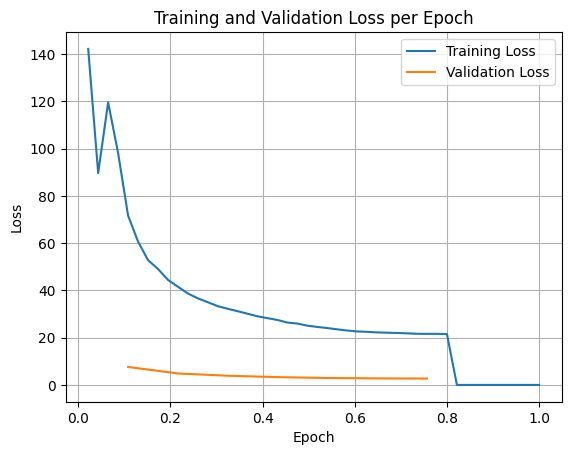

In [26]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
trainer.save_model()

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...sion-v1/training_args.bin: 100%|##########| 6.35kB / 6.35kB            

  ...55771.ab0bd1481fa3.1357.0: 100%|##########| 31.1kB / 31.1kB            

  ...Vision-v1/tokenizer.model: 100%|##########| 4.70MB / 4.70MB            

  ...-Vision-v1/tokenizer.json: 100%|##########| 33.4MB / 33.4MB            

  ...adapter_model.safetensors:  28%|##7       | 41.8MB /  150MB            

## Test the trained model

In [28]:
from peft import PeftModel
from transformers import AutoModelForImageTextToText, AutoProcessor

MODEL_ID = 'google/gemma-3n-E2B-it'

# Load the saved model
loaded_model = AutoModelForImageTextToText.from_pretrained(MODEL_ID,
                                                           low_cpu_mem_usage=True,
                                                           device_map='auto')

processor = AutoProcessor.from_pretrained(MODEL_ID)



config.json:   0%|          | 0.00/4.25k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/159k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/2.82G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

In [29]:
CHECKPOINT_DIR_NAME = args.output_dir #'/content/drive/MyDrive/ColabNotebooks/vlm_finetune/gemma-3n-FoodExtract-Vision-v1/checkpoint-35'
CHECKPOINT_DIR_NAME

adapter_path = CHECKPOINT_DIR_NAME
print (f" [INFO] Loading adatper from: {adapter_path}")
loaded_model.load_adapter(adapter_path, adapter_name="food_extractor_adapter") # Specify a unique adapter name
print(f' [INFO] Loaded model adapter successfully!')

 [INFO] Loading adatper from: gemma-3n-FoodExtract-Vision-v1
 [INFO] Loaded model adapter successfully!


In [30]:
# Method 1: Check if peft_config exists and list adapters
if hasattr(loaded_model, 'peft_config'):
    print("Adapters loaded:", list(loaded_model.peft_config.keys()))
    print("Active adapter:", getattr(loaded_model, 'active_adapter', None))
else:
    print("No PEFT adapters loaded")

# Method 2: Check active adapters directly
if hasattr(loaded_model, 'active_adapters'):
    print("Active adapters:", loaded_model.active_adapters())


Adapters loaded: ['food_extractor_adapter']
Active adapter: None
Active adapters: ['food_extractor_adapter']


[INFO] Random sample model input:
{'role': 'user', 'content': [{'type': 'image', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x612 at 0x7B77E840FB00>}, {'type': 'text', 'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n    'food_items' : [], #\xa0list[str] - list of visible edible food item nouns\n    'drink_items': [] #\xa0list[str] - list of visible edible drink item nouns\n}\n```\n"}]}

[INFO] Random sample model output:
{'role': 'assistant', 'content': [{'type': 'text', 'text': {'is_food': 1, 'image_title': 'Smoothi

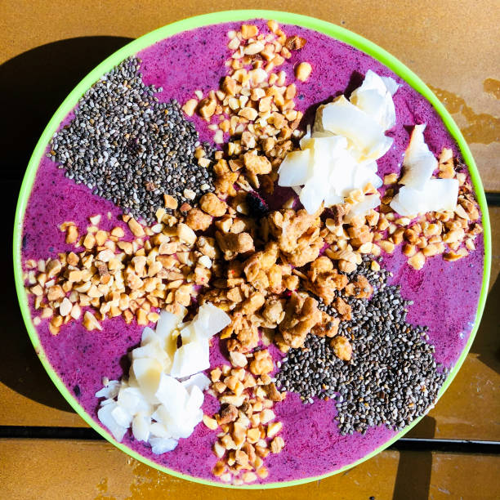

In [34]:
random_val_sample = random.choice(val_dataset)
random_val_sample_model_input = random_val_sample['messages'][1]
random_val_sample_model_output = random_val_sample['messages'][-1]
random_val_sample_image = random_val_sample_model_input['content'][0]['image']

print(f'[INFO] Random sample model input:\n{random_val_sample_model_input}')
print()
print(f'[INFO] Random sample model output:\n{random_val_sample_model_output}')

random_val_sample_image.resize((500,500))


In [46]:
#DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#loaded_model.to("cuda");

In [35]:
# Run the model on our example sample
val_chat_template_input = processor.apply_chat_template(
    [random_val_sample_model_input],
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors='pt'
).to(device)#DEVICE # Move input to model's device and dtype, ensuring type consistency

# example_chat_template_input

input_len = val_chat_template_input["input_ids"].shape[-1]
print(f"[INFO] Input length: {input_len}")

with torch.inference_mode():
  val_generation_output_full = loaded_model.generate(**val_chat_template_input,
                                    max_new_tokens=256,
                                    do_sample=False)
  val_generation_output_short = val_generation_output_full[0][input_len:]

val_decoded_outputs = processor.decode(val_generation_output_short,
                                   skip_special_tokens=True)

print(val_decoded_outputs)

[INFO] Input length: 446
```json
{
    'is_food': 1,
    'image_title': 'Smoothie Bowl with Toppings',
    'food_items' : ['smoothie', 'chia seeds', 'nuts', 'coconut flakes'],
    'drink_items': []
}
```


### Test the custom image

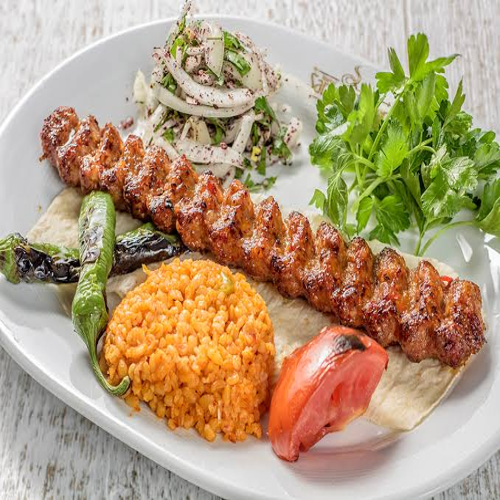

In [36]:
image_path ='/content/IMG_3808.JPG'
image = Image.open(image_path)
image =image.resize((500,500))
image

In [38]:
random_val_sample_model_input

{'role': 'user',
 'content': [{'type': 'image',
   'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x612>},
  {'type': 'text',
   'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n    'food_items' : [], #\xa0list[str] - list of visible edible food item nouns\n    'drink_items': [] #\xa0list[str] - list of visible edible drink item nouns\n}\n```\n"}]}

In [39]:
def format_sample_to_message(input_image):
  return{'role': 'user',
 'content': [{'type': 'image',
   'image': input_image},
  {'type': 'text',
   'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n    'food_items' : [], #\xa0list[str] - list of visible edible food item nouns\n    'drink_items': [] #\xa0list[str] - list of visible edible drink item nouns\n}\n```\n"}]}

In [40]:
test_input_sample = format_sample_to_message(image)
test_input_sample

{'role': 'user',
 'content': [{'type': 'image',
   'image': <PIL.Image.Image image mode=RGB size=500x500>},
  {'type': 'text',
   'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n    'food_items' : [], #\xa0list[str] - list of visible edible food item nouns\n    'drink_items': [] #\xa0list[str] - list of visible edible drink item nouns\n}\n```\n"}]}

In [42]:
# Run the model on our example sample
val_chat_template_input = processor.apply_chat_template(
    [test_input_sample],
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors='pt'
).to(device)#DEVICE # Move input to model's device and dtype, ensuring type consistency

# example_chat_template_input

input_len = val_chat_template_input["input_ids"].shape[-1]
print(f"[INFO] Input length: {input_len}")

with torch.inference_mode():
  val_generation_output_full = loaded_model.generate(**val_chat_template_input,
                                    max_new_tokens=256,
                                    do_sample=False)
  val_generation_output_short = val_generation_output_full[0][input_len:]

val_decoded_outputs = processor.decode(val_generation_output_short,
                                   skip_special_tokens=True)

print(val_decoded_outputs)

[INFO] Input length: 446
```json
{
    'is_food': 1,
    'image_title': 'Kebab and Rice',
    'food_items' : ['Kebab', 'Rice', 'Tomato', 'Green chili pepper', 'Salad'],
    'drink_items': []
}
```


[INFO] Model outputs: ```json
{
    'is_food': 1,
    'image_title': 'Kebab and Rice',
    'food_items' : ['Kebab', 'Rice', 'Tomato', 'Green chili pepper', 'Salad'],
    'drink_items': []
}
```


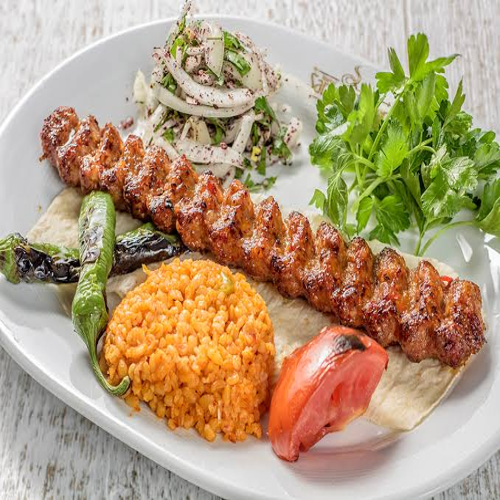

In [43]:
print(f"[INFO] Model outputs: {val_decoded_outputs}")
image.resize(size=(500, 500))

## Uploading the model to the Drive

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
import shutil
import os
from google.colab import drive


if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')


source_dir = args.output_dir
destination_dir = "/content/drive/MyDrive/ColabNotebooks/vlm_finetune/gemma-3n-FoodExtract-Vision-v1"

print(f"[INFO] Model kopyalanıyor...\nKaynak: {source_dir}\nHedef:  {destination_dir}")


try:

    shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)
    print(f"\n[BAŞARILI] Model Google Drive'a başarıyla kaydedildi! ✅")
    print(f"Konum: {destination_dir}")
except Exception as e:
    print(f"\n[HATA] Kayıt sırasında bir sorun oluştu: {e} ❌")

[INFO] Model kopyalanıyor...
Kaynak: gemma-3n-FoodExtract-Vision-v1
Hedef:  /content/drive/MyDrive/ColabNotebooks/vlm_finetune/gemma-3n-FoodExtract-Vision-v1

[BAŞARILI] Model Google Drive'a başarıyla kaydedildi! ✅
Konum: /content/drive/MyDrive/ColabNotebooks/vlm_finetune/gemma-3n-FoodExtract-Vision-v1


### Notes

* **Datatypes:** Make sure model inputs are the same dtype as the model loaded (e.g. if model is quantized, inputs should be quanized too or if model is bfloat16, inputs should be bfloat16 as well)

* **Prompt inputs:** If not using `transformers.pipeline` beware that the system_prompt may have to be folded into the user_prompt, otherwise there will be errors.